# Convolutional Neural Network - Sigmoid


### Import Packages


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

## Check If GPU Enabled

Latest functioning version set as of October 6, 2024 according to https://www.tensorflow.org/install/source_windows is

-   Python 3.10.11
-   Tensorflow 2.10
-   CUDA Toolkit 11.2
-   CUDNN 8.1


In [2]:
# tf.debugging.set_log_device_placement(True) # For Verbose Output
print("Version: ", tf.__version__)
print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("TensorFlow is using GPU")
    for gpu in gpus:
        print(gpu.name)
else:
    print("TensorFlow is not using GPU")

Version:  2.10.0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU
/physical_device:GPU:0


## Binary Pick Mars or Moon


In [75]:
moon = False
train = False

## Pick Datasets to Train or Test


In [70]:
if train:
    if moon:
        lunar_train_dir = r"../../data/lunar/training/data/S12_GradeA"
        num_of_events = len(
            [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
        )
        print("Lunar Number of Events: ", num_of_events)
        event = [i for i in range(15)]  # num_of_events

    else:
        mars_train_dir = r"../../data/mars/training/data/"
        num_of_events = len(
            [file for file in os.listdir(mars_train_dir) if file.endswith(".csv")]
        )
        print("Mars Number of Events: ", num_of_events)
        event = [i for i in range(2)]  # num_of_events

else:
    if moon:
        lunar_train_dir = r"../../data/lunar/test/data/S12_GradeB/"
        num_of_events = len(
            [file for file in os.listdir(lunar_train_dir) if file.endswith(".csv")]
        )
        print("Lunar Number of Events: ", num_of_events)
        event = [i for i in range(num_of_events)]  # num_of_events

    else:
        mars_train_dir = r"../../data/mars/test/data/"
        num_of_events = len(
            [file for file in os.listdir(mars_train_dir) if file.endswith(".csv")]
        )
        print("Mars Number of Events: ", num_of_events)
        event = [i for i in range(num_of_events)]  # num_of_events

Mars Number of Events:  9


## Import Catalog


In [76]:
if train:
    if moon:
        catalog_path = (
            r"../../data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
        )
        catalog = pd.read_csv(catalog_path)

    else:
        catalog_path = (
            r"../../data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"
        )
        catalog = pd.read_csv(catalog_path)

catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


## Get Filename and, if train, Anomaly Position


In [79]:
if train:
    if moon:
        event_filename = [catalog["filename"][i] + r".csv" for i in event]
        print("Event Filenames:", event_filename)

        true_anomaly_time = [int(catalog["time_rel(sec)"][i]) for i in event]
        print("Anomaly Positions in Each File:", true_anomaly_time)

    else:
        event_filename = [catalog["filename"][i] for i in event]
        print("Event Filenames:", event_filename)

        true_anomaly_time = [int(catalog["time_rel(sec)"][i]) for i in event]
        print("Anomaly Positions in Each File:", true_anomaly_time)

else:
    if moon:
        event_filename = [
            file
            for file in os.listdir(lunar_train_dir) + r".csv"
            if file.endswith(".csv")
        ]
        print("Event Filenames:", event_filename)

    else:
        event_filename = [
            file for file in os.listdir(mars_train_dir) if file.endswith(".csv")
        ]
        print("Event Filenames:", event_filename)

Event Filenames: ['XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv', 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.csv', 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv', 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv', 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv', 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.csv', 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv', 'XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv']


## Load Lunar Training Data


In [82]:
if train:
    if moon:
        csv_files_path = r"../../data/lunar/training/data/S12_GradeA"
        csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
        print(csv_files)
    else:
        csv_files_path = r"../../data/mars/training/data"
        csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
        print(csv_files)

else:
    if moon:
        csv_files_path = r"../../data/lunar/test/data/S12_GradeB"
        csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
        print(csv_files)
    else:
        csv_files_path = r"../../data/mars/test/data/"
        csv_files = [os.path.join(csv_files_path, file) for file in event_filename]
        print(csv_files)

['../../data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv', '../../data/mars/test/data/XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv']


## Get Length, Time, and Speed of Each Event

Load all .csv's into one dataframe. Additionally, take the standard normal value of the velocity values, _i.e._

$$
    X_{standard} = \frac{X - \mu_X}{\sigma_X}.
$$


In [83]:
lens_array = []
time_arrays = []
data_arrays = []
for file in csv_files:
    df = pd.read_csv(file)

    lens_array.append(len(df))

    if moon:
        t = df["time_rel(sec)"].values
        time_arrays.append(t)

        X = df["velocity(m/s)"].values
        X_standard = (X - np.mean(X)) / np.std(X)
        data_arrays.append(X_standard)
    else:
        t = df["rel_time(sec)"].values
        time_arrays.append(t)

        X = df["velocity(c/s)"].values
        X_standard = (X - np.mean(X)) / np.std(X)
        data_arrays.append(X_standard)


time_array = np.concatenate(time_arrays)
data_array = np.concatenate(data_arrays)

if moon:
    time = pd.DataFrame(time_array, columns=["time_rel(sec)"])
    seismic_data = pd.DataFrame(data_array, columns=["velocity(m/s)"])
else:
    time = pd.DataFrame(time_array, columns=["rel_time(sec)"])
    seismic_data = pd.DataFrame(data_array, columns=["velocity(c/s)"])

# print("Time Shape: ", np.array(time_arrays).shape)

## Data Preparation


In [84]:
if moon:
    X_standard = seismic_data["velocity(m/s)"].values
else:
    X_standard = seismic_data["velocity(c/s)"].values


X_standard = X_standard.astype(np.float32)  # To save memory

## Create Window Sequences


In [87]:
windows_size = 16
batch_size = 500

# Create sequences for CNN
windows = []
for i in range(len(X_standard) - windows_size):
    windows.append(X_standard[i : i + windows_size])

windows = np.array(windows)

In [88]:
print(windows.shape)

(647983, 16)


## Get True Anomaly Labels

Places a 0 in `y` for all the values before `anomaly_pos` and 1 for all the values after `anomaly_pos`. Creates a sigmoid labelling.


In [91]:
if train:
    width = 20
    if moon:
        freq = 6.625
    else:
        freq = 20
    sampling_freq = 1 / freq

    y = np.zeros(len(X_standard[windows_size:]))

    for anomaly_index in range(len(true_anomaly_time)):

        length = lens_array[anomaly_index]
        start = np.sum(lens_array[j] for j in range(anomaly_index))
        end = start + length
        print("Length of event:", length)
        print("[Start, End]:", "[", start, ",", end, "]")

        anomaly = true_anomaly_time[anomaly_index]
        print("Anomaly position:", anomaly)

        sigma = int(width)
        center = int(anomaly * freq)
        y[start + center - sigma : end] = 1
        print(
            "Range of 1s:",
            "[",
            start + center - sigma,
            ",",
            start + center + sigma,
            "]",
        )
        print("===================")

    print("===================")
    print("y shape:", y.shape)
    print("Non-zero elements in y:", np.count_nonzero(y))

In [13]:
# def early_detection_loss(y_true, y_pred, anomaly_time, time_array):
#     loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, label_smoothing=0.05)
#     time_penalty = np.abs(time_array - anomaly_time)  # Higher penalty for later times
#     weighted_loss = loss * time_penalty
#     return tf.reduce_mean(weighted_loss)

## Model Layers


In [92]:
label_smoothing = 0.05
n_epochs = 2

# Reshape your input data
windows = np.array(windows).reshape(-1, windows_size, 1)

In [16]:
# Create the CNN model
model = models.Sequential()


# Input Layer
model.add(layers.Conv1D(windows_size, 3, input_shape=(windows_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))


# Down Sampling Layers
model.add(layers.Conv1D(2 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))  # 6


# Up Sampling Layers
model.add(layers.Conv1DTranspose(4 * windows_size, 3))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))

model.add(layers.Conv1DTranspose(2 * windows_size, 1))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.UpSampling1D(size=2))


# Output Layer
model.add(Flatten())
model.add(layers.Dense(1, activation="sigmoid"))


# Compile the model
# optimizer = Adam(learning_rate=0.1)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
    metrics=["accuracy"],
)

## Train the Autoencoder using Real Data Only


In [ ]:
history = model.fit(windows, y, epochs=n_epochs, batch_size=batch_size)

## Plot the Accuracy Change Over Epochs


In [ ]:
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

## Plot the Model Change Over Epochs


In [ ]:
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Predict/Detect Anomalies

Calculate the reconstruction error on new data.


In [ ]:
reconstructed = model.predict(windows)

In [ ]:
print("Reconstructed Shape:", reconstructed.shape)
print("Windows Shape:", windows.shape)

## Calculate Mean Squared Error (MSE)


In [ ]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print("MSE Shape:", mse.shape)

## Set a Threshold for Anomaly Detection Based on the MSE Quantile Values


In [ ]:
if moon:
    high1 = np.quantile(np.abs(mse), 0.999)
    # high2 = np.quantile(np.abs(mse), 0.9951)
    anomalies_label = [1 if i > high1 else 0 for i in mse]
    print("Predicted Anomaly Position:", np.argmax(anomalies_label))
    print(
        "Predicted Number of Anomalies:",
        np.count_nonzero(anomalies_label),
        "(depends directly on the quantile range)",
    )
else:
    high1 = np.quantile(np.abs(mse), 0.996)
    high2 = np.quantile(np.abs(mse), 0.999)
    anomalies_label = [1 if i > high1 and i < high2 else 0 for i in mse]
    print("Predicted Anomaly Position:", np.argmax(anomalies_label))
    print(
        "Predicted Number of Anomalies:",
        np.count_nonzero(anomalies_label),
        "(depends directly on the quantile range)",
    )

## Plot the Seismic Data and Scatterplot of the Predicted Data of Every Event Input


In [ ]:
cumulative = 0
for i in event:
    length = lens_array[i]
    print(length)

    tiempo = time_arrays[i]
    X = data_arrays[i]
    plt.figure(figsize=(10, 6))
    plt.plot(
        tiempo,
        X,
        label="Seismic Activity",
        color="k",
    )

    anomaly_indices = np.where(anomalies_label)[0]
    print("Anomaly Indices:", anomaly_indices)

    anomaly_indices_in_event = np.array(
        [j for j in anomaly_indices if cumulative <= j and j <= cumulative + length]
    )
    print("Anomaly Indices in Event:", anomaly_indices_in_event)

    arrival_line = plt.axvline(
        x=true_anomaly_time[i], c="green", label="True Arrival Time"
    )
    arrival_line = plt.axvline(
        x=(anomaly_indices_in_event - cumulative)[0] / 20.0,
        c="red",
        label="Predicted Arrival Time",
    )

    plt.scatter(
        time_array[anomaly_indices_in_event + windows_size],
        data_array[anomaly_indices_in_event + windows_size],
        color="yellow",
        label="Anomalies",
        marker="o",
        s=1,
        zorder=2,
    )

    plt.title(f"Seismic Activity for Event {i + 1}")
    plt.xlabel("Time (Relative Seconds)")
    plt.ylabel("Normalized Velocity (m/s)")
    plt.legend()
    plt.show()  # Show the plot for the current event

    cumulative += length

## EXTRA: Confusion Matrix

Not really valid...


In [ ]:
conf_matrix = confusion_matrix(y, anomalies_label)

display = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=["Normal", "Anomaly"]
)

display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Extract Model


In [ ]:
model.summary()

In [65]:
if moon:
    model.save(
        f"cnn_sigmoid_moon_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.keras"
    )
    model.save(
        f"cnn_sigmoid_moon_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.h5"
    )
else:
    model.save(
        f"cnn_sigmoid_mars_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.keras"
    )
    model.save(
        f"cnn_sigmoid_mars_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.h5"
    )

# Extract Data


In [64]:
results_df = pd.DataFrame(
    {
        "true_labels": y,
        "predictions": reconstructed.flatten(),
        "mse": mse,
        "anomalies": anomalies_label,
    }
)

anomalies_df = pd.DataFrame(
    {"time_rel(sec)": time_array[windows_size:], "anomalies": anomalies_label}
)

if moon:
    results_df.to_csv("./extract/cnn_sigmoid_moon_seismic_results.csv", index=False)
    anomalies_df.to_csv("./extract/cnn_sigmoid_moon_seismic_anomalies.csv", index=False)
else:
    results_df.to_csv("./extract/cnn_sigmoid_mars_seismic_results.csv", index=False)
    anomalies_df.to_csv("./extract/cnn_sigmoid_mars_seismic_anomalies.csv", index=False)

## Load Saved Model


In [95]:
moon = True
num_of_events = 15
windows_size = 16
batch_size = 500
label_smoothing = 0.05
n_epochs = 10

In [118]:
if not train:
    if moon:
        freq = 6.625
        loaded_model = tf.keras.models.load_model(
            f"../../trained_models/cnn_sigmoid_moon_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.keras"
        )
    else:
        freq = 20
        loaded_model = tf.keras.models.load_model(
            f"../../trained_models/cnn_sigmoid_mars_events{num_of_events}_windowsize{windows_size}_batchsize{batch_size}_smoothing{label_smoothing}_epochs{n_epochs}.keras"
        )

    loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 16)            64        
                                                                 
 batch_normalization (BatchN  (None, 14, 16)           64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 16)            0         
                                                                 
 dropout (Dropout)           (None, 14, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            1568      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 32)           128       
 hNormalization)                                        

In [ ]:
# loaded_model.evaluate(windows, y, verbose=2)

In [111]:
reconstructed = loaded_model.predict(windows)

20250/20250 [==============================] - 49s 2ms/step


In [112]:
print("Reconstructed Shape:", reconstructed.shape)
print("Windows Shape:", windows.shape)

Reconstructed Shape: (647983, 1)
Windows Shape: (647983, 16, 1)


In [113]:
mse = np.mean(np.power(windows[:, :, 0] - reconstructed, 2), axis=1)
print("MSE Shape:", mse.shape)

MSE Shape: (647983,)


In [114]:
if moon:
    high1 = np.quantile(np.abs(mse), 0.999)
    # high2 = np.quantile(np.abs(mse), 0.9951)
    anomalies_label = [1 if i > high1 else 0 for i in mse]
    print("Predicted Anomaly Position:", np.argmax(anomalies_label))
    print(
        "Predicted Number of Anomalies:",
        np.count_nonzero(anomalies_label),
        "(depends directly on the quantile range)",
    )
else:
    high1 = np.quantile(np.abs(mse), 0.9)
    anomalies_label = [1 if i > high1 else 0 for i in mse]
    print("Predicted Anomaly Position:", np.argmax(anomalies_label))
    print(
        "Predicted Number of Anomalies:",
        np.count_nonzero(anomalies_label),
        "(depends directly on the quantile range)",
    )

Predicted Anomaly Position: 45764
Predicted Number of Anomalies: 647 (depends directly on the quantile range)


72000
Anomaly Indices: [ 45764  45765  45766  45767  45768  45769  45770  45771  45772  45773
  45774  45775  45776  45777  45778  45779  45780  45781  45782  45783
  45784  45785  45786  45787  45788  45789  45790  45791  45792  45793
  45794  45795  45796  45797  45798  45799  45800  45801  45802  45803
  45804  45805  45806  45807  45808  45809  45810  45811  45812  45813
  45814  45815  45816  45817  45818  45819  45820  45821  45822  45823
  45824  45825  45826  45827  45828  45829  45830  45831  45832  45833
  45834  45835  45836  45837  45838  45839  45840  45841  45842  45843
  45844  45845  45846  45847  45848  45849  45850  45851  45852  45853
  45854  45855  45856  45857  45858  45859  45860  45861  45862  45863
  45864  45865  45866  45867  45868  45869  45870  45871  45872  45873
  45874  45875  45876  45877  45878  45879  45880  45881  87106  87107
  87108  87109  87110  87111  87112  87113  87114  87115  87116  87117
  87118  87119  87120  87121  87122  87123  87124  871

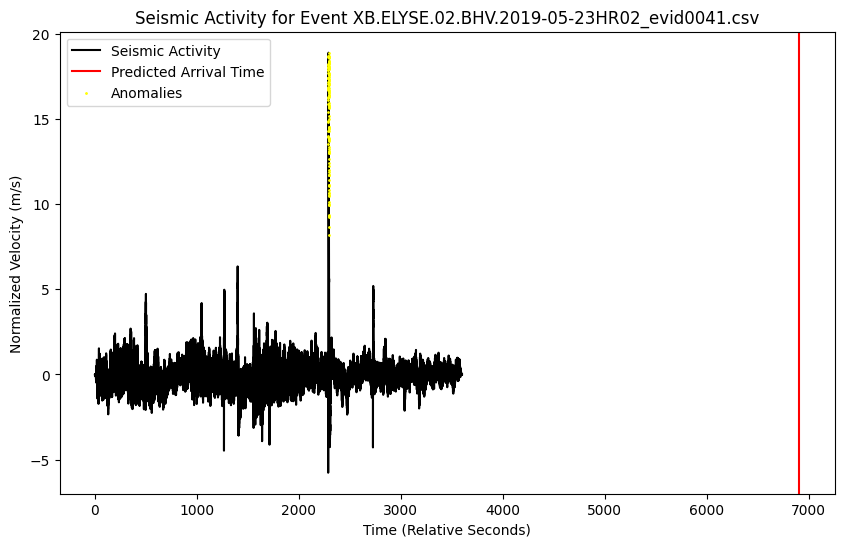

72000
Anomaly Indices: [ 45764  45765  45766  45767  45768  45769  45770  45771  45772  45773
  45774  45775  45776  45777  45778  45779  45780  45781  45782  45783
  45784  45785  45786  45787  45788  45789  45790  45791  45792  45793
  45794  45795  45796  45797  45798  45799  45800  45801  45802  45803
  45804  45805  45806  45807  45808  45809  45810  45811  45812  45813
  45814  45815  45816  45817  45818  45819  45820  45821  45822  45823
  45824  45825  45826  45827  45828  45829  45830  45831  45832  45833
  45834  45835  45836  45837  45838  45839  45840  45841  45842  45843
  45844  45845  45846  45847  45848  45849  45850  45851  45852  45853
  45854  45855  45856  45857  45858  45859  45860  45861  45862  45863
  45864  45865  45866  45867  45868  45869  45870  45871  45872  45873
  45874  45875  45876  45877  45878  45879  45880  45881  87106  87107
  87108  87109  87110  87111  87112  87113  87114  87115  87116  87117
  87118  87119  87120  87121  87122  87123  87124  871

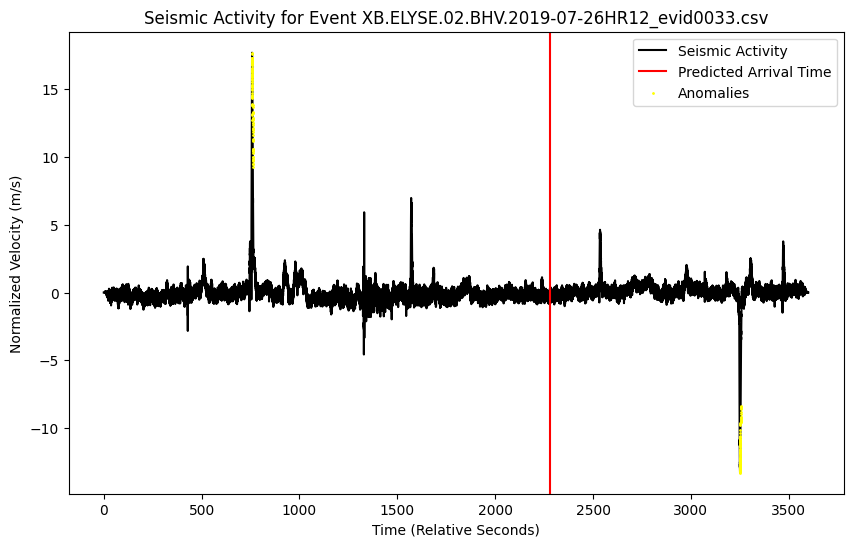

72000
Anomaly Indices: [ 45764  45765  45766  45767  45768  45769  45770  45771  45772  45773
  45774  45775  45776  45777  45778  45779  45780  45781  45782  45783
  45784  45785  45786  45787  45788  45789  45790  45791  45792  45793
  45794  45795  45796  45797  45798  45799  45800  45801  45802  45803
  45804  45805  45806  45807  45808  45809  45810  45811  45812  45813
  45814  45815  45816  45817  45818  45819  45820  45821  45822  45823
  45824  45825  45826  45827  45828  45829  45830  45831  45832  45833
  45834  45835  45836  45837  45838  45839  45840  45841  45842  45843
  45844  45845  45846  45847  45848  45849  45850  45851  45852  45853
  45854  45855  45856  45857  45858  45859  45860  45861  45862  45863
  45864  45865  45866  45867  45868  45869  45870  45871  45872  45873
  45874  45875  45876  45877  45878  45879  45880  45881  87106  87107
  87108  87109  87110  87111  87112  87113  87114  87115  87116  87117
  87118  87119  87120  87121  87122  87123  87124  871

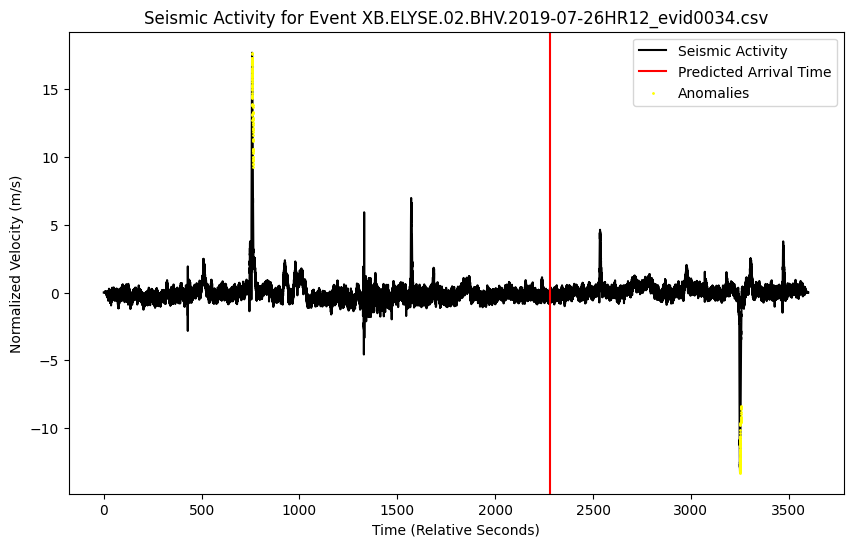

72000
Anomaly Indices: [ 45764  45765  45766  45767  45768  45769  45770  45771  45772  45773
  45774  45775  45776  45777  45778  45779  45780  45781  45782  45783
  45784  45785  45786  45787  45788  45789  45790  45791  45792  45793
  45794  45795  45796  45797  45798  45799  45800  45801  45802  45803
  45804  45805  45806  45807  45808  45809  45810  45811  45812  45813
  45814  45815  45816  45817  45818  45819  45820  45821  45822  45823
  45824  45825  45826  45827  45828  45829  45830  45831  45832  45833
  45834  45835  45836  45837  45838  45839  45840  45841  45842  45843
  45844  45845  45846  45847  45848  45849  45850  45851  45852  45853
  45854  45855  45856  45857  45858  45859  45860  45861  45862  45863
  45864  45865  45866  45867  45868  45869  45870  45871  45872  45873
  45874  45875  45876  45877  45878  45879  45880  45881  87106  87107
  87108  87109  87110  87111  87112  87113  87114  87115  87116  87117
  87118  87119  87120  87121  87122  87123  87124  871

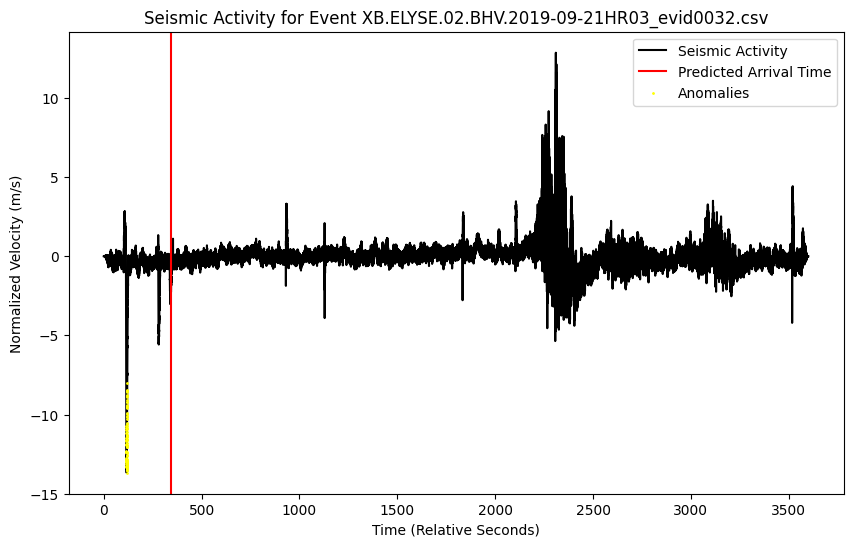

72000
Anomaly Indices: [ 45764  45765  45766  45767  45768  45769  45770  45771  45772  45773
  45774  45775  45776  45777  45778  45779  45780  45781  45782  45783
  45784  45785  45786  45787  45788  45789  45790  45791  45792  45793
  45794  45795  45796  45797  45798  45799  45800  45801  45802  45803
  45804  45805  45806  45807  45808  45809  45810  45811  45812  45813
  45814  45815  45816  45817  45818  45819  45820  45821  45822  45823
  45824  45825  45826  45827  45828  45829  45830  45831  45832  45833
  45834  45835  45836  45837  45838  45839  45840  45841  45842  45843
  45844  45845  45846  45847  45848  45849  45850  45851  45852  45853
  45854  45855  45856  45857  45858  45859  45860  45861  45862  45863
  45864  45865  45866  45867  45868  45869  45870  45871  45872  45873
  45874  45875  45876  45877  45878  45879  45880  45881  87106  87107
  87108  87109  87110  87111  87112  87113  87114  87115  87116  87117
  87118  87119  87120  87121  87122  87123  87124  871

IndexError: index 0 is out of bounds for axis 0 with size 0

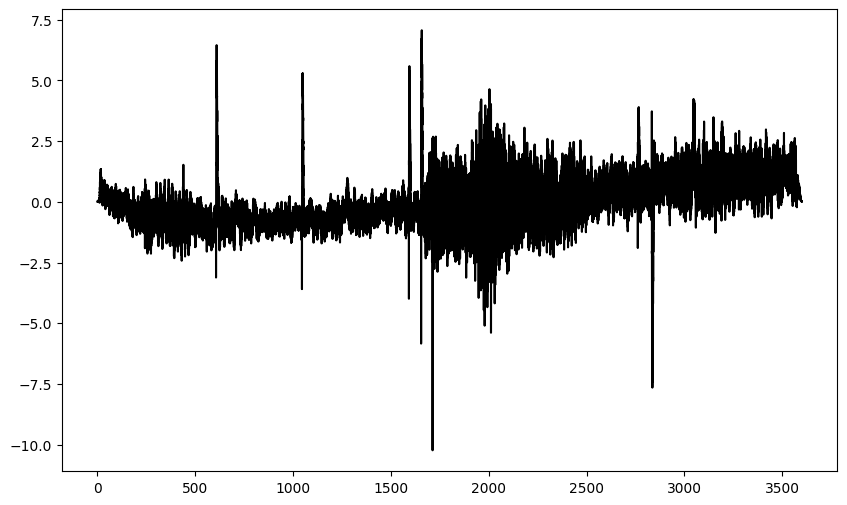

In [115]:
cumulative = 0
for i in event:
    length = lens_array[i]
    print(length)

    tiempo = time_arrays[i]
    X = data_arrays[i]
    plt.figure(figsize=(10, 6))
    plt.plot(
        tiempo,
        X,
        label="Seismic Activity",
        color="k",
    )

    anomaly_indices = np.where(anomalies_label)[0]
    print("Anomaly Indices:", anomaly_indices)

    anomaly_indices_in_event = np.array(
        [j for j in anomaly_indices if cumulative <= j and j <= cumulative + length]
    )
    print("Anomaly Indices in Event:", anomaly_indices_in_event)

    arrival_line = plt.axvline(
        x=(anomaly_indices_in_event - cumulative)[0] / freq,
        c="red",
        label="Predicted Arrival Time",
    )

    plt.scatter(
        time_array[anomaly_indices_in_event + windows_size],
        data_array[anomaly_indices_in_event + windows_size],
        color="yellow",
        label="Anomalies",
        marker="o",
        s=1,
        zorder=2,
    )

    plt.title(f"Seismic Activity for Event {event_filename[i]}")
    plt.xlabel("Time (Relative Seconds)")
    plt.ylabel("Normalized Velocity (m/s)")
    plt.legend()
    plt.savefig(f"../../predictions/lunar/{event_filename[i]}.png")
    # plt.savefig(f"../../predictions/lunar/{event_filename[i]}_with_scatter.png")
    plt.show()  # Show the plot for the current event

    cumulative += length